# Importando as bibliotecas

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Função de erosão

In [29]:
def erosao(image, elemEstruturante):
    # executando a erosão binária de uma imagem c/ o elemento estruturante
    m, n = elemEstruturante.shape
    
    # definindo a origem do elemento estruturante (assumindo como centro)
    origem_m, origem_n = m // 2, n // 2

    # preenchendo as bordas com zero para tratar os limites da imagem
    pad_top = origem_m
    pad_bottom = m - origem_m - 1
    pad_left = origem_n
    pad_right = n - origem_n - 1
    padded = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=0)
    
    img_erodida = np.zeros_like(image)
    
    # varrendo cada pixel da imagem original
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # extraindo a região vizinha de tamanho igual ao do elemEstruturante
            regiao = padded[i:i + m, j:j + n]
            # verifica se, para os pixels onde o elemento estruturante é 1,
            # a região também contém 1 em todos esses pontos.
            if np.all(regiao[elemEstruturante == 1]):
                img_erodida[i, j] = 1
    return img_erodida

# Função de dilatação

In [30]:
def dilatacao(image, elemEstruturante):
    elemEstLinhas = len(elemEstruturante)
    elemEstColunas = len(elemEstruturante[0]) if elemEstLinhas > 0 else 0
    linhaOrigem = elemEstLinhas // 2  # definindo centro do elem Estruturante
    colunaOrigem = elemEstColunas // 2
    img_linhas = len(image)
    img_colunas = len(image[0]) if img_linhas > 0 else 0
    
    # cria umsss matriz preenchida com 0s
    result = np.zeros_like(image)
    
    # percorrendo a img
    for i in range(img_linhas):
        for j in range(img_colunas):
            # Só processa pixels ativos na img original
            if image[i][j] == 1:
                # aplicando o elemest
                for di in range(elemEstLinhas):
                    for dj in range(elemEstColunas):
                        if elemEstruturante[di][dj] == 1:
                            ni = i - linhaOrigem + di
                            nj = j - colunaOrigem + dj
                            # limite da img
                            if 0 <= ni < img_linhas and 0 <= nj < img_colunas:
                                result[ni][nj] = 1
    return result

# Função de hit_or_miss

In [31]:
def hit_or_miss(a, x, w):
    p1 = erosao(a, x)
    p2 = erosao((1 - a), w)
    return p1 * p2

# Função de esqueletização

In [32]:
# formula Sk(A) = (A erosao kB) - (A erosao kB) abertura B
def esqueletizacao(imagem, B):
    esqueleto = np.zeros_like(imagem)
    
    while np.any(imagem):  # enquanto houver pixel
        erodida = erosao(imagem, B)
        abertura = dilatacao(erodida, B)
        
        # calcula td vez a camada do esqueleto como a subtracao entre a img atual e a abertura
        esqueleto += imagem - abertura
        
        # att img como erodida
        imagem = erodida
        
    return esqueleto

# Função de afinamento

In [33]:
def afinamento(img, b):
    aux = img.copy()
    for i in range(20):
        for ee in b:
            aux = aux ^ hit_or_miss(aux, ee[0], ee[1])
    return aux

# Função de poda

In [34]:
def poda(img, B, BEE):
    X1 = img.copy()
    for i in range(3):  # equação 9.5-17, repete 3 vezes
        X1 = afinamento(X1, BEE)  # A ⊗ {B}
    
    # extraindo extremidades aplicando hit-or-miss com cada ee e fazer a união
    X2 = np.zeros_like(img, dtype=bool)
    for ee in BEE:
        X2 = np.logical_or(X2, hit_or_miss(X1, ee[0], ee[1])) # tava Bk in b, e passando como argumento Bk, Bk
    
    # dilatação c/ condicional (X2 ⊕ H) ∩ A, aplicado três vezes
    X3 = X2.copy()
    for i in range(3):
        X3 = np.logical_and(dilatacao(X3, B), img)
    
    # união X4 = X1 ∪ X3
    X4 = np.logical_or(X1, X3)
    
    return X4


# Processando e mostrando a imagem original

Text(0.5, 1.0, 'Imagem Original')

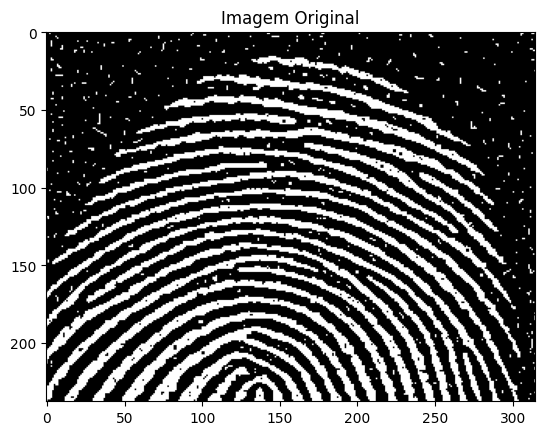

In [35]:
image = Image.open('digital.png').convert('L')
img_array = np.array(image)
img_binaria = (img_array > 128).astype(np.uint8)
plt.figure()
plt.imshow(img_binaria, cmap='gray')
plt.title('Imagem Original')


# Processando e mostrando a imagem aberta

Text(0.5, 1.0, 'Imagem aberta')

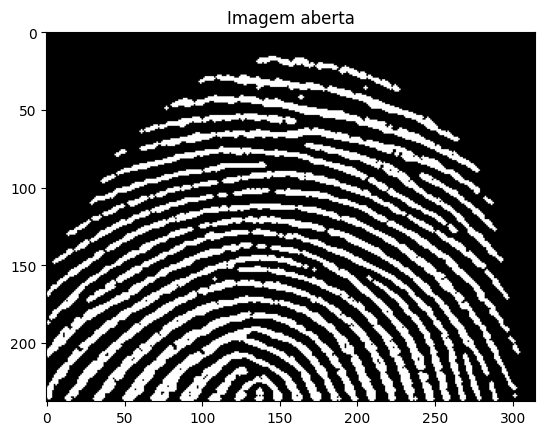

In [36]:
elemEstruturanteA = np.array([[0, 1, 0],
                  [1, 1, 1],
                  [0, 1, 0]], dtype=np.uint8)

img_aberta = dilatacao(erosao(img_binaria, elemEstruturanteA), elemEstruturanteA)
plt.figure()
plt.imshow(img_aberta, cmap='gray')
plt.title('Imagem aberta')

# Processando e mostrando a imagem fechada

Text(0.5, 1.0, 'Imagem fechada')

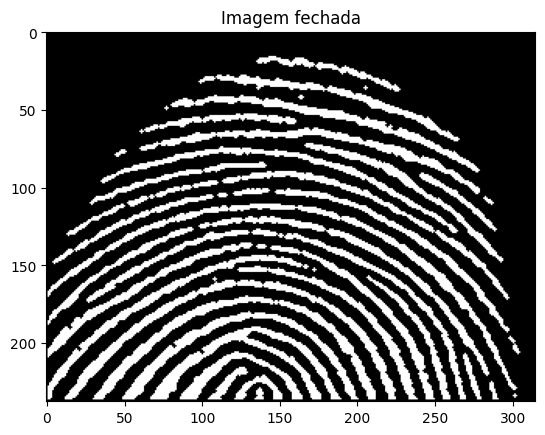

In [37]:
img_fechada = erosao(dilatacao(img_aberta, elemEstruturanteA), elemEstruturanteA)
plt.figure()
plt.imshow(img_fechada, cmap='gray')
plt.title('Imagem fechada')

# Processando e mostrando a imagem esqueletizada

Text(0.5, 1.0, 'Imagem esqueletizada')

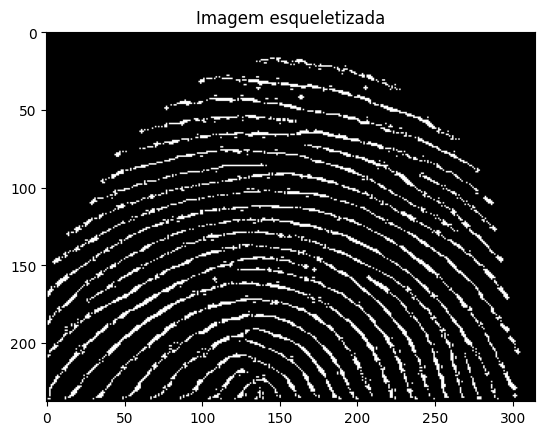

In [38]:
b = np.ones((3, 3)).astype('uint8')
img_esq = esqueletizacao(img_fechada, b)
plt.figure()
plt.imshow(img_esq, cmap='gray')
plt.title('Imagem esqueletizada')

# Elementos estruturantes para a poda

In [39]:

b1 = np.zeros((3, 3))
b1[1, 1] = 1
b1[2, :] = 1

b1c = np.zeros((3, 3))
b1c[0, :] = 1

b2 = b1.T
b2c = b1c.T

b3 = b1.copy()
b3[0, :] = 1
b3[2, :] = 0

b3c = b1c.copy()
b3c[0, :] = 0
b3c[2, :] = 1

b4 = b3.T
b4c = b3c.T

bee = [[b1, b1c], [b2, b2c], [b3, b3c], [b4, b4c]]

# Processando e mostrando a imagem podada

Text(0.5, 1.0, 'Imagem podada')

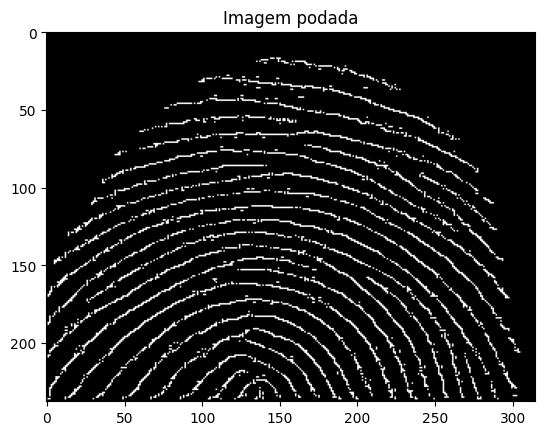

In [40]:
img_podada = poda(img_esq, b, bee)
plt.figure()
plt.imshow(img_podada, cmap='gray')
plt.title('Imagem podada')